In [5]:
from DLtools.Data import instant_data,intersection,del_less_col,station_sel,check_specific_col
from DLtools.evaluation_rec import real_eva_error,record_list_result
from DLtools.feature_sel import call_mar
from DLtools.MachineLearning import test_stationarity,tsplot

import warnings
warnings.filterwarnings('ignore')

import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
np.random.seed(42)

# Load data

In [6]:
###### SETTING AREA ################
loading = instant_data()
# df,mode,n_past,n_future = loading.hourly_instant(),'hour',24*7,72
df,mode,n_past,n_future = loading.daily_instant(),'day',60,14

st = 'CPY012'
target,start_p,stop_p,host_path=station_sel(st,mode)
save_path = host_path
#######################################################
def scope_data(data):
    global start_p,stop_p
    # return del_less_col(data[start_p:stop_p],0.8)
    return data[start_p:stop_p]
#######################################################
df_r = scope_data(loading.df_r)
df_w = scope_data(loading.df_w)
df_wet = scope_data(loading.df_wet)
df_dam = scope_data(loading.df_d)

df_solar = df_wet[check_specific_col(df_wet,'solar')]
df_rain1h = df_wet[check_specific_col(df_wet,'rain1h')]
df_temp = df_wet[check_specific_col(df_wet,'temp')]
df_press = df_wet[check_specific_col(df_wet,'press')]
#######################################################
# df_r = scope_data(loading.df_r)

* Filter ratio 80%, interpolation NaN

In [7]:
data = df[start_p:stop_p]
# data = del_less_col(data,ratio=.80)
# data['Day'] = data.index.dayofyear #add day
data = data.interpolate(limit=300000000,limit_direction='both').astype('float32')#interpolate neighbor first, for rest NA fill with mean() #.apply(lambda x: x.fillna(x.mean()),axis=0)

In [8]:
df_rainST = pd.read_csv(f'/home/song/Public/Song/Work/Thesis/data/hii-telemetering-batch-data-master/station_metadata-rain.csv')
df_waterST = pd.read_csv(f'/home/song/Public/Song/Work/Thesis/data/hii-telemetering-batch-data-master/station_metadata-water-level.csv')
df_weatherST = pd.read_csv(f'/home/song/Public/Song/Work/Thesis/data/hii-telemetering-weather-data-master/station_metadata.csv')

* filter ST only avaliable 80% data

In [15]:
def clean_list(df_st,sel_word):
    global data
    data_col = list(data.columns)
    data_col = [i.split("_") for i in data_col]
    _col =list()
    if sel_word=='':
        for i in data_col:_col.append(i[0])
    else:
        for i in data_col:
            if i[1]==sel_word : _col.append(i[0])
    dis_loc = intersection(_col,list(df_st['code']))
    df_st = df_st.loc[df_st['code'].isin(dis_loc)]
    return df_st

In [16]:
df_rainST = clean_list(df_rainST,'rain')
df_waterST = clean_list(df_waterST,'wl')
df_weatherST = clean_list(df_weatherST,'')

In [17]:
df_rainST

code                  name        lat        long           tambon  \
504  YOM002             เชียงม่วน  18.946189  100.258886              สระ   
505  NAN002               ภูเพียง  18.859726  100.817126         เมืองจัง   
506  YOM009       โพธิ์ประทับช้าง  16.310781  100.271763  โพธิ์ประทับช้าง   
508  WAN001                สามเงา  17.260589   99.077958          วังหมัน   
509  WAN003                  เถิน  17.751757   99.230662           แม่ถอด   
..      ...                   ...        ...         ...              ...   
936  TB0005         อบต.เจริญธรรม  14.378085  101.000243        เจริญธรรม   
939  TB0006          ทต.ทุ่งสะโตก  18.573922   98.862195        ทุ่งสะโตก   
941  TB0002           สะพานสองแคว  18.862501  100.641158          สะเนียน   
943  TB0001              บ้านกาใส  18.864016  100.676288          สะเนียน   
970  TB0007  ที่ว่าการอำเภอแม่วาง  18.612670   98.775238          บ้านกาด   

              amphoe   province            basin    region station_type  \
504        เชียงม่วน      พะเยา         แม่น้ำยม  ภาคเหนือ            W   
505          ภูเพียง       น่าน       แม่น้ำน่าน  ภาคเหนือ            W   
506  โพธิ์ประทับช้าง     พิจิตร         แม่น้ำยม  ภาคเหนือ            W   
508           สามเงา        ตาก        แม่น้ำวัง  ภาคเหนือ            W   
509             เถิน      ลำปาง        แม่น้ำวัง  ภาคเหนือ            W   
..               ...        ...              ...       ...          ...   
936         วิหารแดง    สระบุรี  แม่น้ำเจ้าพระยา   ภาคกลาง            R   
939        สันป่าตอง  เชียงใหม่        แม่น้ำปิง  ภาคเหนือ            W   
941        เมืองน่าน       น่าน       แม่น้ำน่าน  ภาคเหนือ            W   
943        เมืองน่าน       น่าน       แม่น้ำน่าน  ภาคเหนือ            W   
970           แม่วาง  เชียงใหม่        แม่น้ำปิง  ภาคเหนือ            R   

                       geometry  
504  POINT (100.25889 18.94619)  
505  POINT (100.81713 18.85973)  
506  POINT (100.27176 16.31078)  
508   POINT (99.07796 17.26059)  
509   POINT (99.23066 17.75176)  
..                          ...  
936  POINT (101.00024 14.37808)  
939   POINT (98.86220 18.57392)  
941  POINT (100.64116 18.86250)  
943  POINT (100.67629 18.86402)  
970   POINT (98.77524 18.61267)  

[137 rows x 11 columns]

In [18]:
CPY = df_waterST.loc[df_waterST['code']=='CPY012']

# Map display

In [19]:
import geopandas as gpd
path_w = "/home/song/Public/Song/Work/Thesis/data/map/TH_water/Wtr_body.shp"
path_t = '/home/song/Public/Song/Work/Thesis/data/map/Th_map/thailand.shp'
watermap = gpd.read_file(path_w)
thaimap = gpd.read_file(path_t)

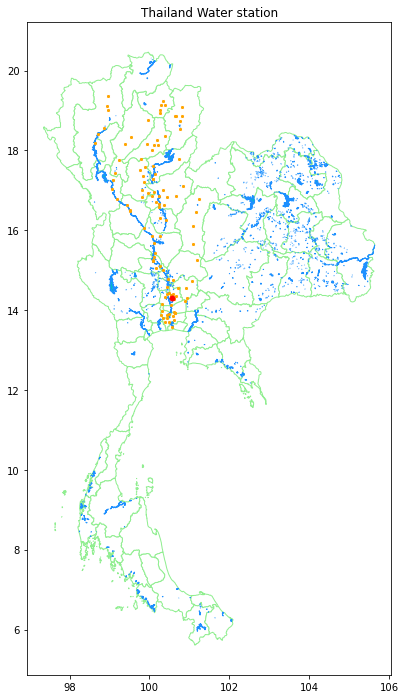

In [20]:
fig, ax = plt.subplots(1,figsize=(7,12))

thai = thaimap.plot(axes=ax,color='white', edgecolor='lightgreen')
water = watermap.plot(ax=ax,color='c', edgecolor='dodgerblue')
# #station map
station_map = gpd.GeoDataFrame(df_waterST, geometry=gpd.points_from_xy(df_waterST.long, df_waterST.lat))
CPY_station_map = gpd.GeoDataFrame(CPY, geometry=gpd.points_from_xy(CPY.long, CPY.lat))

ax.set_title('Thailand Water station')
station_map.plot(ax=ax, color='orange',marker="x",markersize=5)
CPY_station_map.plot(ax=ax, color='red',marker="o",markersize=25)
plt.savefig('watermap.png')

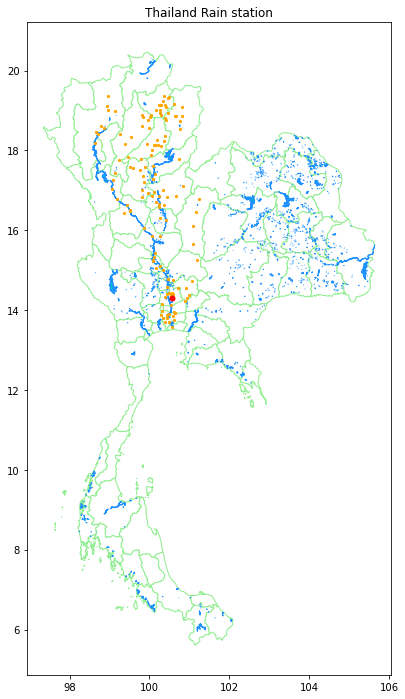

In [21]:
fig, ax = plt.subplots(1,figsize=(7,12))
thai = thaimap.plot(axes=ax,color='white', edgecolor='lightgreen')
water = watermap.plot(ax=ax,color='c', edgecolor='dodgerblue')
# station
rain_station_map = gpd.GeoDataFrame(df_rainST, geometry=gpd.points_from_xy(df_rainST.long, df_rainST.lat))

ax.set_title('Thailand Rain station')
rain_station_map.plot(ax=ax, color='orange',marker="x",markersize=5)
CPY_station_map.plot(ax=ax, color='red',marker="o",markersize=25)
plt.savefig('rainmap.png')

# Outlier detect

In [102]:
sns.boxplot(data=df_dam)

NameError: name 'df_dam' is not defined